**INTRODUCTION**

**About This Project**

With the growing volume of digital transactions in India, particularly through UPI (Unified Payments Interface), ensuring the security of transactions and detecting fraudulent behavior has become more crucial than ever. This project aims to apply machine learning techniques to identify fraudulent UPI transactions using various transactional, demographic, and temporal features.

This is a binary classification problem, where the goal is to predict whether a given transaction is fraudulent or genuine.

**Dataset Source**

The Dataset used in this project was sourced from Kaggle and the link has been provided:

*Dataset Link:* https://www.kaggle.com/datasets/skullagos5246/upi-transactions-2024-dataset

The Dataset provides a rich set of categorical, temporal, and behavioral features, essential for training an effective fraud detection model

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

**READING AND PRE-PROCESSING THE DATASET**

In [66]:
upi_df = pd.read_csv('DataSets/upi_transactions_2024.csv')
print(upi_df.head(10))

  transaction id            timestamp transaction type merchant_category  \
0  TXN0000000001  2024-10-08 15:17:28              P2P     Entertainment   
1  TXN0000000002  2024-04-11 06:56:00              P2M           Grocery   
2  TXN0000000003  2024-04-02 13:27:18              P2P           Grocery   
3  TXN0000000004  2024-01-07 10:09:17              P2P              Fuel   
4  TXN0000000005  2024-01-23 19:04:23              P2P          Shopping   
5  TXN0000000006  2024-10-07 22:32:07              P2P              Food   
6  TXN0000000007  2024-02-08 10:25:57              P2P             Other   
7  TXN0000000008  2024-10-27 18:47:02              P2P         Utilities   
8  TXN0000000009  2024-11-21 09:39:16              P2P             Other   
9  TXN0000000010  2024-11-11 15:58:56              P2M           Grocery   

   amount (INR) transaction_status sender_age_group receiver_age_group  \
0           868            SUCCESS            26-35              18-25   
1          1011

Printing the Metadata of the Dataset.

In [67]:
print(upi_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   transaction id      250000 non-null  object
 1   timestamp           250000 non-null  object
 2   transaction type    250000 non-null  object
 3   merchant_category   250000 non-null  object
 4   amount (INR)        250000 non-null  int64 
 5   transaction_status  250000 non-null  object
 6   sender_age_group    250000 non-null  object
 7   receiver_age_group  250000 non-null  object
 8   sender_state        250000 non-null  object
 9   sender_bank         250000 non-null  object
 10  receiver_bank       250000 non-null  object
 11  device_type         250000 non-null  object
 12  network_type        250000 non-null  object
 13  fraud_flag          250000 non-null  int64 
 14  hour_of_day         250000 non-null  int64 
 15  day_of_week         250000 non-null  object
 16  is

Now we convert the `timestamp` column to a proper `datetime` object.

In [68]:
upi_df['timestamp'] = pd.to_datetime(upi_df['timestamp'])

In [69]:
upi_df['sender_state'].value_counts()

sender_state
Maharashtra       37427
Uttar Pradesh     30125
Karnataka         29756
Tamil Nadu        25367
Delhi             24870
Telangana         22435
Gujarat           20061
Andhra Pradesh    20006
Rajasthan         19981
West Bengal       19972
Name: count, dtype: int64

In [70]:
categorical_features = ['transaction id', 'transaction type', 'merchant_category', 'transaction_status',
                    'sender_age_group', 'receiver_age_group', 'sender_state', 'sender_bank',
                    'receiver_bank', 'device_type', 'network_type', 'day_of_week']


**EXPLORATARY DATA ANALYSIS**

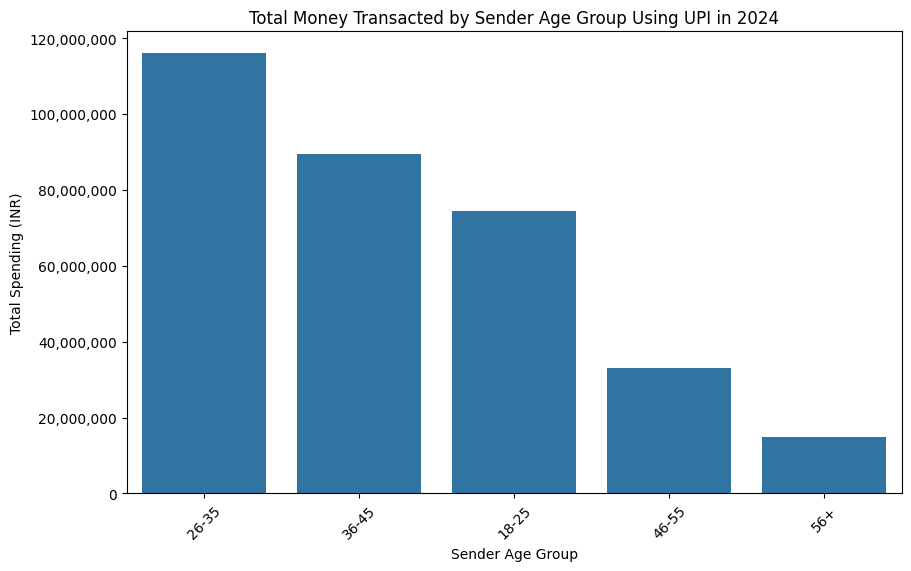

In [71]:
# We first plot a bar chart between different age groups and their spending.
sender_spend = upi_df.groupby('sender_age_group')['amount (INR)'].sum().sort_values(ascending=False)


plt.figure(figsize=(10, 6))
sn.barplot(x=sender_spend.index, y=sender_spend.values)
plt.xlabel("Sender Age Group")
plt.ylabel("Total Spending (INR)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Total Money Transacted by Sender Age Group Using UPI in 2024")
plt.show()

So from the above Bar Plot it is clear that the Sender Age Group of `26-35` have transacted the most using UPI in 2024, while the Age Group `56+` have done so the least.

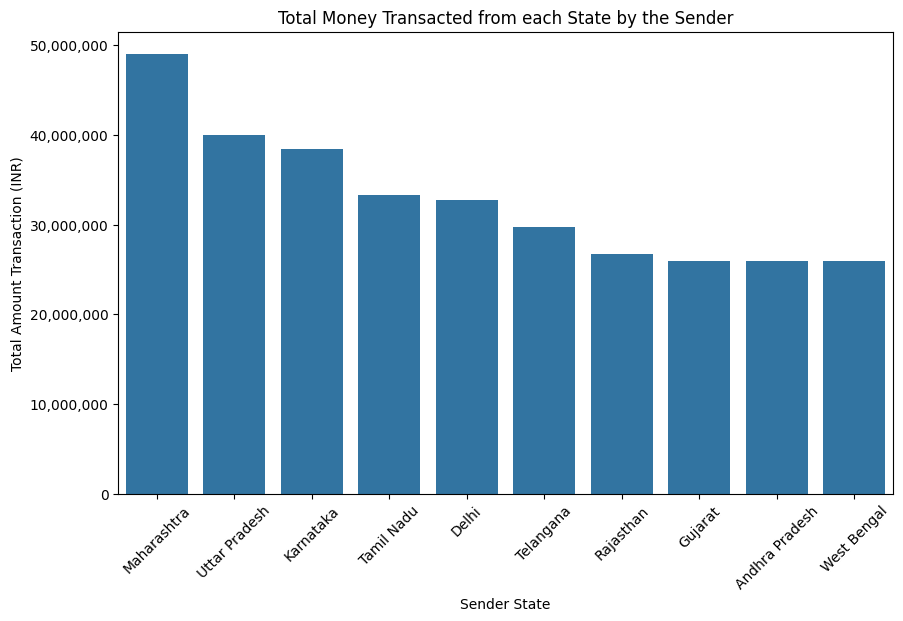

In [72]:
# Now we do a sender state-wise analysis of the expenditure using a bar-chart
sender_spend_statewise = upi_df.groupby('sender_state')['amount (INR)'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sn.barplot(x=sender_spend_statewise.index, y=sender_spend_statewise.values)
plt.title("Total Money Transacted from each State by the Sender")
plt.xlabel("Sender State")
plt.ylabel("Total Amount Transaction (INR)")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.show()

So here we see that People from the `sender_state` Maharashtra have the highest transaction amount in the year 2024, while West Bengal has the lowest

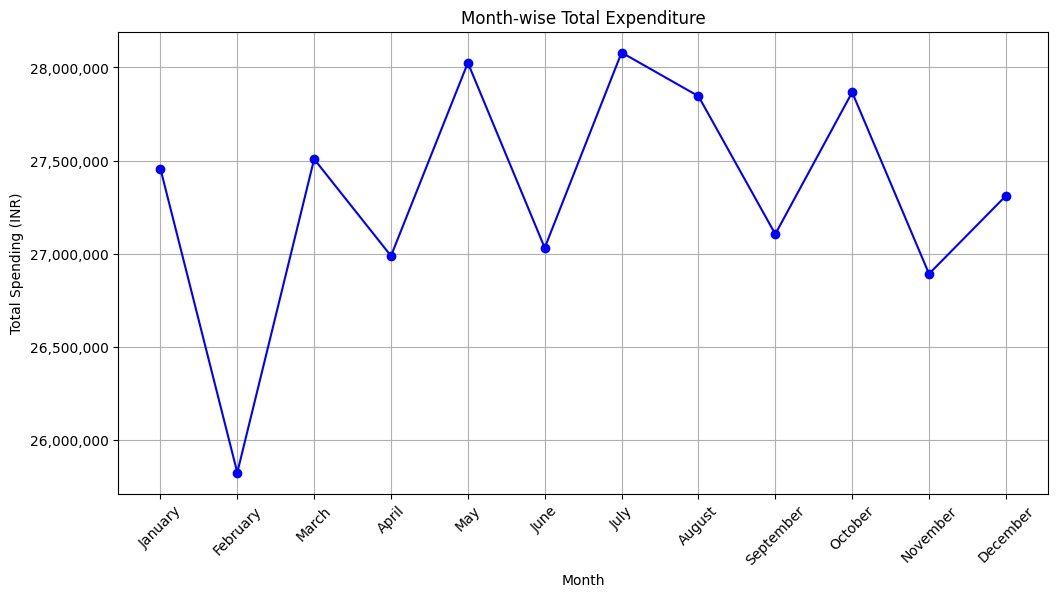

In [73]:
# Next we see the Month-wise Money Transaction trend of 2024.

upi_df['month'] = upi_df['timestamp'].dt.month_name()
upi_df['month_num'] = upi_df['timestamp'].dt.month

monthly_expenditure = upi_df.groupby(['month_num', 'month'])['amount (INR)'].sum().reset_index()
monthly_expenditure = monthly_expenditure.sort_values('month_num')

plt.figure(figsize=(12, 6))
plt.plot(monthly_expenditure['month'], monthly_expenditure['amount (INR)'], marker='o', linestyle='-', color='blue')
plt.title("Month-wise Total Expenditure")
plt.xlabel("Month")
plt.ylabel("Total Spending (INR)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.grid()
plt.show()

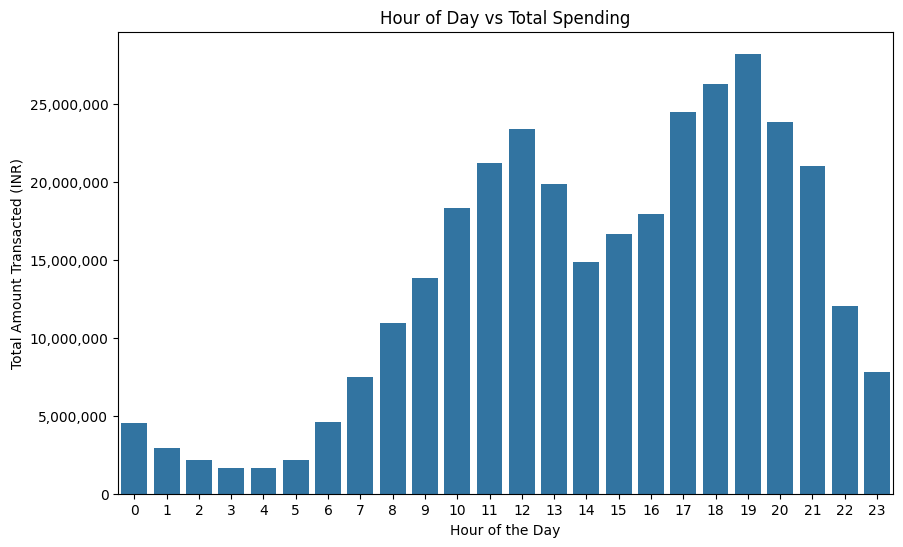

In [74]:
# Now we shall track the Hour of Day vs Total Spending to see which Hour of the day the most and
# least expenditures are done in a day.
hourly_spend = upi_df.groupby('hour_of_day')['amount (INR)'].sum()

plt.figure(figsize=(10, 6))
sn.barplot(x=hourly_spend.index, y=hourly_spend.values)
plt.title("Hour of Day vs Total Spending")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Amount Transacted (INR)")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

So from the bar plot we can see that at the 19th hour of the day (i.e. 7-8 pm) the people have made the most transactions and at the 3rd hour of the day (i.e. 3-4 am) the people have made the least transactions.

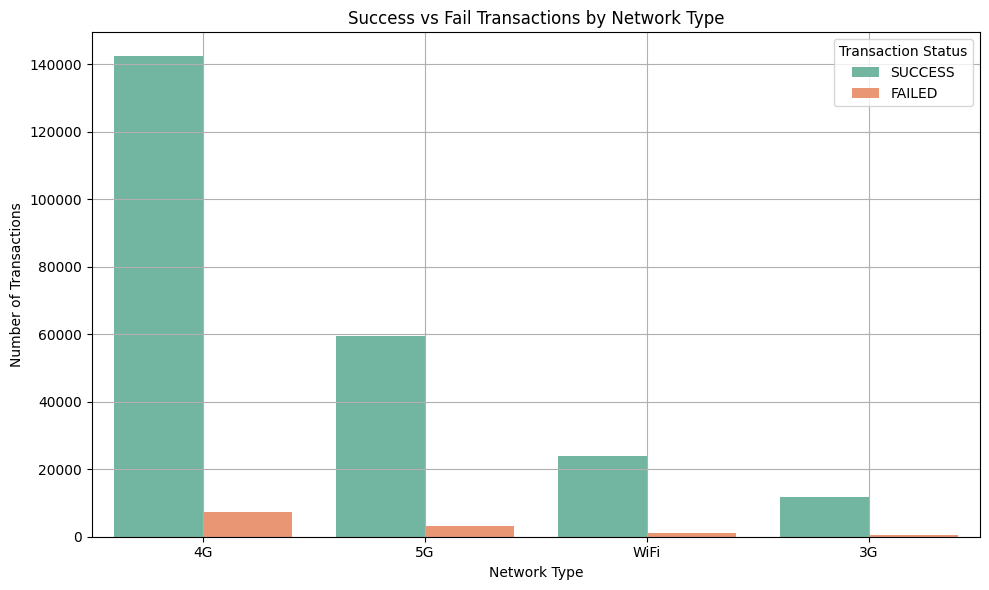

In [75]:
# Now we shall check the Payment Status vs the Type of Network used.
plt.figure(figsize=(10,6))
sn.countplot(data=upi_df, x='network_type', hue='transaction_status', palette='Set2')

plt.title('Success vs Fail Transactions by Network Type')
plt.xlabel('Network Type')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Status')
plt.tight_layout()
plt.grid()
plt.show()


So here we see that, most of the transactions made in 2024 have been done using the `Network Type` **4G** while least number of transactions have been done using **3G** `Network Type`.

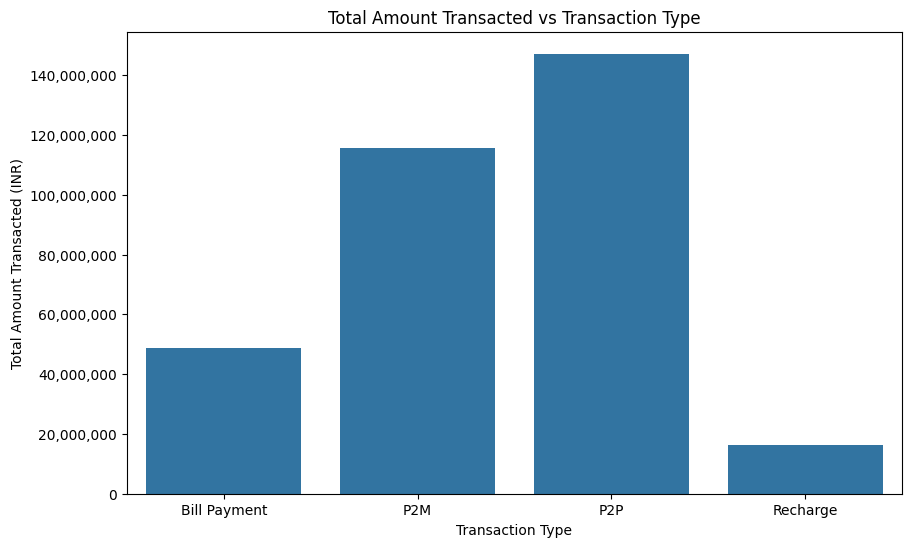

In [76]:
# We plot a bar char to check on which Transaction Type people spend more.
type_spend = upi_df.groupby('transaction type')['amount (INR)'].sum()
plt.figure(figsize=(10, 6))
sn.barplot(x=type_spend.index, y=type_spend.values)
plt.xlabel("Transaction Type")
plt.ylabel("Total Amount Transacted (INR)")
plt.title("Total Amount Transacted vs Transaction Type")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

Here `P2M` is the Transaction Type Peer to Merchant and `P2P` is Peer to Peer.

We observe that the most amount spent is on Peer to Peer type of Transactions and least on Recharge type of Transactions.

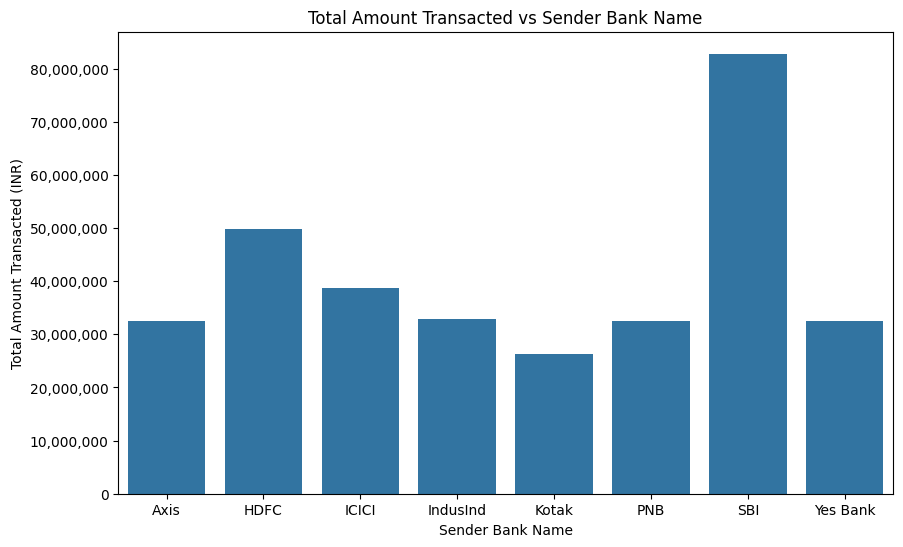

In [77]:
# Bank-wise Transaction Spending.
sender_bank_spend = upi_df.groupby('sender_bank')['amount (INR)'].sum()

plt.figure(figsize=(10, 6))
sn.barplot(x=sender_bank_spend.index, y=sender_bank_spend.values)
plt.xlabel('Sender Bank Name')
plt.ylabel('Total Amount Transacted (INR)')
plt.title("Total Amount Transacted vs Sender Bank Name")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

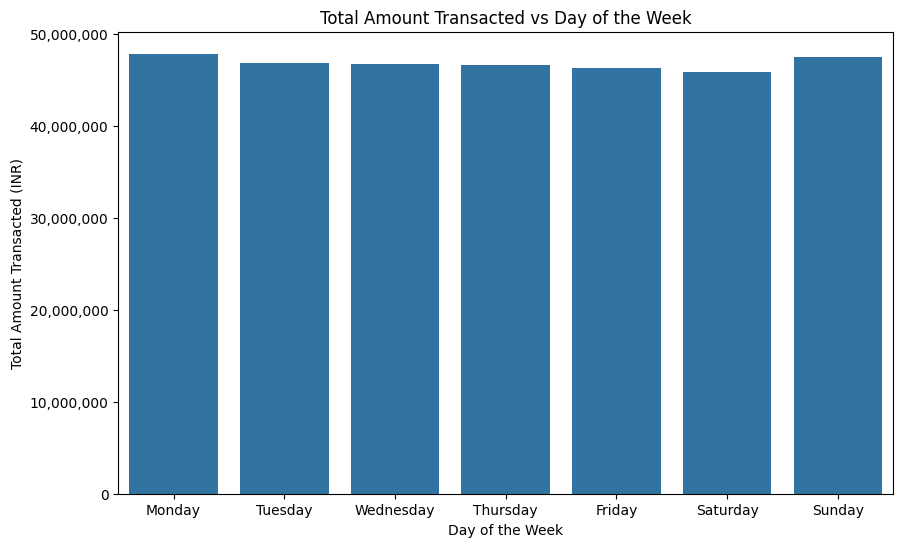

In [78]:
# We check on which Day of the Week most people have transaction made.
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
upi_df['day_of_week'] = pd.Categorical(upi_df['day_of_week'], categories=day_order, ordered=True)

# Group and plot

day_of_week_spend = upi_df.groupby('day_of_week', observed=True)['amount (INR)'].sum()


plt.figure(figsize=(10, 6))
sn.barplot(x=day_of_week_spend.index, y=day_of_week_spend.values)
plt.xlabel('Day of the Week')
plt.ylabel('Total Amount Transacted (INR)')
plt.title("Total Amount Transacted vs Day of the Week")
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

As we can see that every day of the week has nearly the same amount of total money transacted throughout the year.

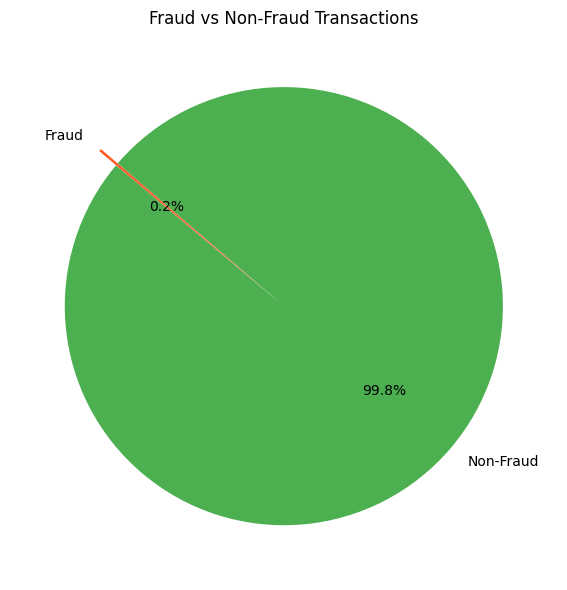

In [79]:
# We now check how many transactions were involved for Fraud vs Non-fraud Transactions
fraud_counts = upi_df['fraud_flag'].value_counts()


labels = ['Non-Fraud', 'Fraud'] if 0 in fraud_counts.index else ['Fraud', 'Non-Fraud']

plt.figure(figsize=(6, 6))
plt.pie(fraud_counts.values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=['#4CAF50', '#FF5722'],
        explode=(0, 0.1) if 1 in fraud_counts.index else (0.1, 0))

plt.title('Fraud vs Non-Fraud Transactions')
plt.tight_layout()
plt.show()

We see there are only 0.2% Fraudelent transactions compared to the 99.8% Non-Fraudelent Transactions.

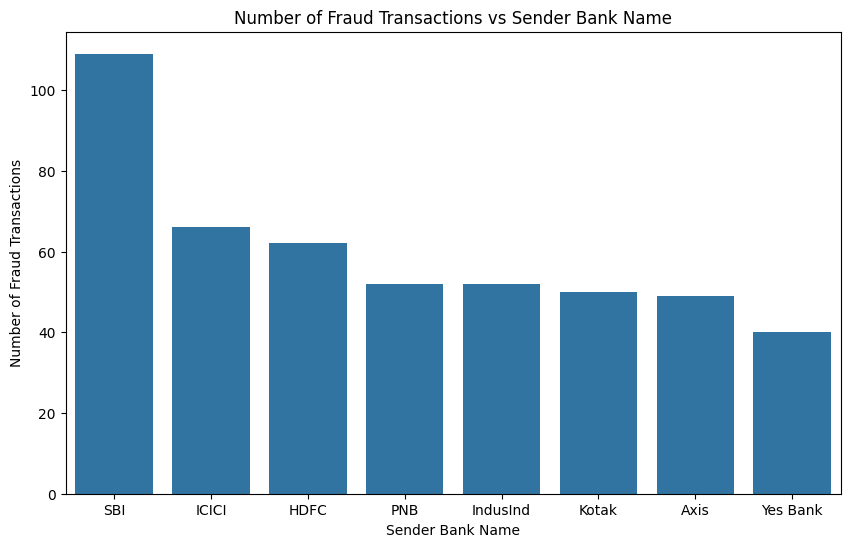

In [108]:
# Checking which Bank has the most Fraudulent Transactions.
fraud_df = upi_df[upi_df['fraud_flag'] == 1]
sender_bank_fraud = fraud_df['sender_bank'].value_counts()

plt.figure(figsize=(10, 6))
sn.barplot(x=sender_bank_fraud.index, y=sender_bank_fraud.values)
plt.xlabel('Sender Bank Name')
plt.ylabel('Number of Fraud Transactions')
plt.title("Number of Fraud Transactions vs Sender Bank Name")
plt.show()

**DATA PRE-PROCESSING FOR MODELING**

First we check for any null or missing values throughout the dataset.

In [80]:
print(upi_df.isnull().sum())

transaction id        0
timestamp             0
transaction type      0
merchant_category     0
amount (INR)          0
transaction_status    0
sender_age_group      0
receiver_age_group    0
sender_state          0
sender_bank           0
receiver_bank         0
device_type           0
network_type          0
fraud_flag            0
hour_of_day           0
day_of_week           0
is_weekend            0
month                 0
month_num             0
dtype: int64


We see that there are no null values for either of the columns.

Now we shall encode categorical values.

In [81]:
categorical_features_m1 = ['transaction type', 'merchant_category', 'sender_age_group', 'receiver_age_group', 'sender_state', 'sender_bank', 'receiver_bank', 'device_type', 'network_type', 'day_of_week']
new_upi_df = upi_df.drop(['transaction id', 'timestamp'], axis=1)
encoded_df = pd.get_dummies(new_upi_df[categorical_features_m1], drop_first=True)
X_m1 = encoded_df

In [82]:
Y_m1 = new_upi_df['fraud_flag']

In [83]:
X_m2 = list(encoded_df.columns)
Y_m2 = new_upi_df['transaction_status']

**BUILDING CLASSIFICATION MODELS**

**1.To predict for `fraud_flag`**

In [84]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_m1, Y_m1, test_size=0.3, random_state=42, stratify=Y_m1)

logit = LogisticRegression()
logit.fit(X1_train, y1_train)

LogisticRegression()

In [85]:
y1_pred_logit = logit.predict(X1_test)


In [86]:
from sklearn import metrics
def draw_roc_curve(model, test_X, test_y):
    test_results_df = pd.DataFrame({'actual': test_y})
    test_results_df = test_results_df.reset_index()

    predict_proba_df = pd.DataFrame(model.predict_proba(test_X))
    test_results_df['chd_1'] = predict_proba_df.iloc[:, 1:2]

    fpr, tpr, thresholds = metrics.roc_curve(test_results_df.actual, test_results_df.chd_1, drop_intermediate=False)

    auc_score = metrics.roc_auc_score(test_results_df.actual, test_results_df.chd_1)

    plt.figure(figsize=(8, 6))

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)

    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate or [1 - true Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characterisic Example')
    plt.legend(loc='lower right')
    plt.show()

    return auc_score, fpr, tpr, thresholds

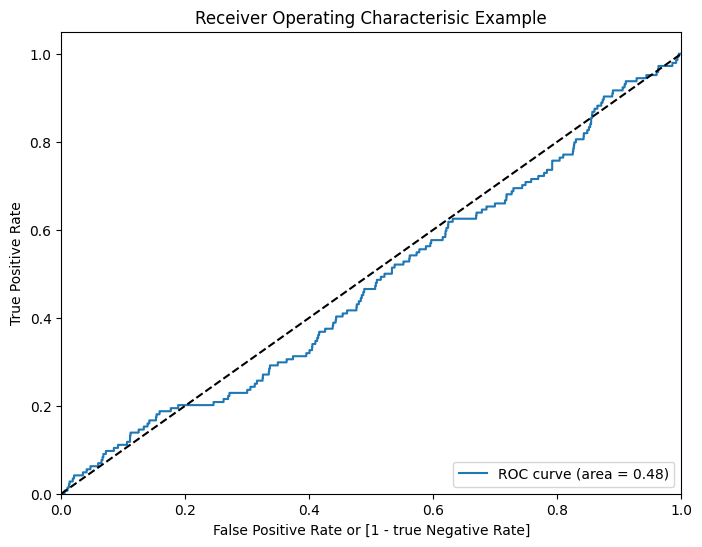

In [87]:
_, _, _, _ = draw_roc_curve(logit, X1_test, y1_test)

In [88]:
radm_clf1 = RandomForestClassifier(max_depth=10, n_estimators=10)
radm_clf1.fit(X1_train, y1_train)

RandomForestClassifier(max_depth=10, n_estimators=10)

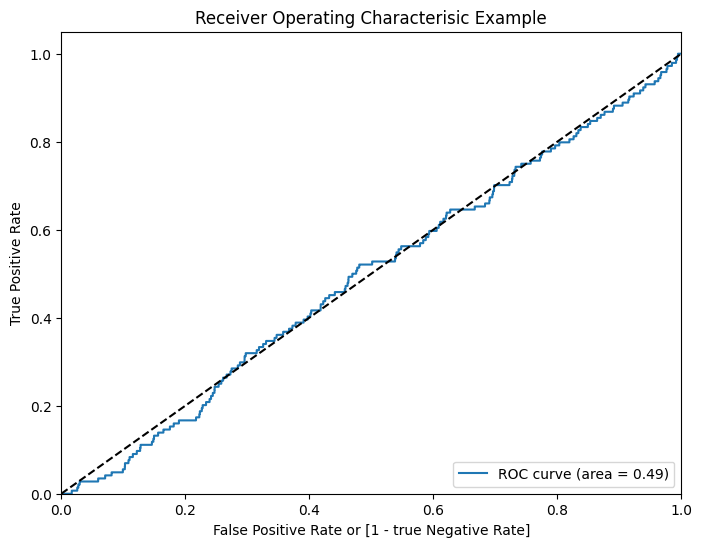

In [89]:
_, _, _, _ = draw_roc_curve(radm_clf1, X1_test, y1_test)

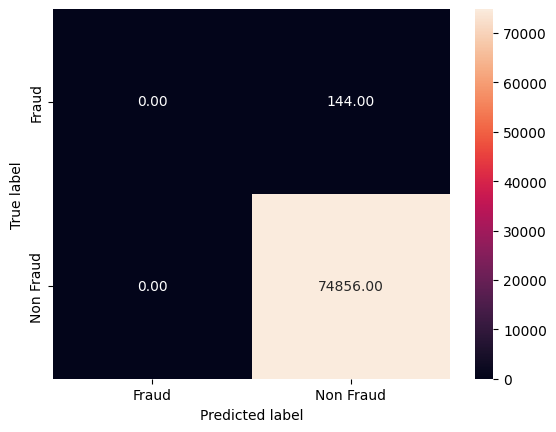

In [90]:
def draw_cm(actual, predicted):
    cm = metrics.confusion_matrix(actual, predicted, labels=[1,0])
    sn.heatmap(cm, annot=True, fmt='.2f', xticklabels = ["Fraud", "Non Fraud"], yticklabels = ["Fraud", "Non Fraud"])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

pred_y1 = radm_clf1.predict(X1_test)
draw_cm(y1_test, pred_y1)

In [91]:
from sklearn.metrics import classification_report
print(classification_report(y1_test, pred_y1, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74856
           1       0.00      0.00      0.00       144

    accuracy                           1.00     75000
   macro avg       0.50      0.50      0.50     75000
weighted avg       1.00      1.00      1.00     75000



From the above data we see that the ROC AUC score for the Logistic Regression Model and the Random Forest Classifier, is low 0.48 and 0.49 respectively, even if the precision, recall and accuracy is 1.00 and also the Confusion Matrix shows that all the Fradulent Values are being classified as Non-Fraud. This is happening due to the Data Set being highly Imabalanced which we can see below.

In [92]:
upi_df['fraud_flag'].value_counts()

fraud_flag
0    249520
1       480
Name: count, dtype: int64

From the data we see that the number of Fraudulent Transactions is really low. This is casuing the model to mark all Fraudulent Data as Non - Fraudulent. To fix this we resample the data to a fixed number, i.e. we Upsample the Fraudulent Values to a certain number and Downsample the Non-Fraudulent Values to a certain number. We choose 10,000 as this fixed number.

So we shall Upsample the Fraudulent Values to 10,000 and Downsample the Non-Fraudulent Values to 10,000.

**Resampling the Data**

***1. Downsampling the Non-Fradulent Values***

In [93]:
from sklearn.utils import resample, shuffle
non_fraud = upi_df[upi_df['fraud_flag'] == 0]
fraud = upi_df[upi_df['fraud_flag'] == 1]

# Downsampling the Number of Non-Fraudelent Transactions
non_fraud_downsampled = resample(non_fraud, replace=False, n_samples=10000, random_state=42)
combined_df = pd.concat([non_fraud_downsampled, fraud])

combined_df['fraud_flag'].value_counts()

fraud_flag
0    10000
1      480
Name: count, dtype: int64

***2. Upsampling the Fradulent Values***

In [94]:
non_fraud = combined_df[combined_df['fraud_flag'] == 0]
fraud = combined_df[combined_df['fraud_flag'] == 1]

fraud_upsampled = resample(fraud, replace=True, n_samples=10000, random_state=42)
combined_df2 = pd.concat([fraud_upsampled, non_fraud])

combined_df2['fraud_flag'].value_counts()



fraud_flag
1    10000
0    10000
Name: count, dtype: int64

We shuffle the dataset to avoid the model to learn the order of Fraudulent and Non-Fraudulent values.

In [95]:
shuffled_df = shuffle(combined_df2, random_state=42)

In [96]:
categorical_features = ['transaction type', 'merchant_category', 'sender_age_group', 'receiver_age_group', 'sender_state', 'sender_bank', 'receiver_bank', 'device_type', 'network_type', 'day_of_week']
new_upi_df = shuffled_df.drop(['transaction id', 'timestamp'], axis=1)
encoded_df = pd.get_dummies(new_upi_df[categorical_features], drop_first=True)
X = encoded_df

In [97]:
Y_1 = shuffled_df['fraud_flag']

In [98]:
train_X1, test_X1, train_y1, test_y1 = train_test_split(X, Y_1, test_size=0.3, random_state=42)

In [99]:
radm_clf = RandomForestClassifier(max_depth=10, n_estimators=100, class_weight="balanced")
radm_clf.fit(train_X1, train_y1)

RandomForestClassifier(class_weight='balanced', max_depth=10)

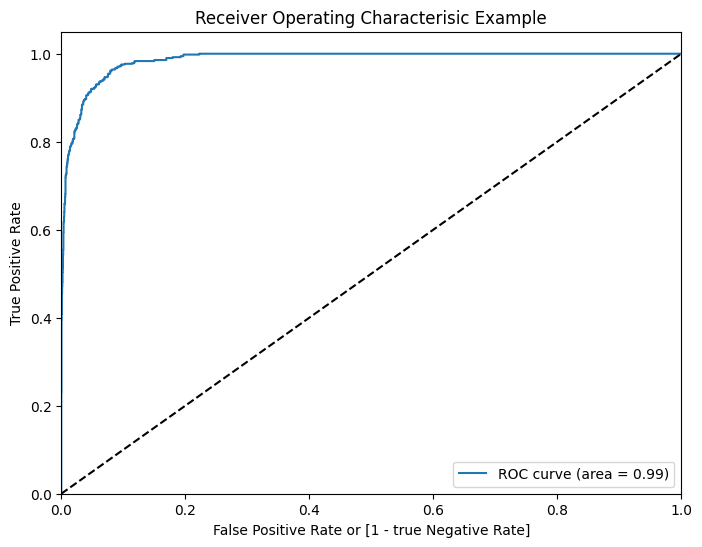

In [100]:
_, _, _, _ = draw_roc_curve(radm_clf, test_X1, test_y1)

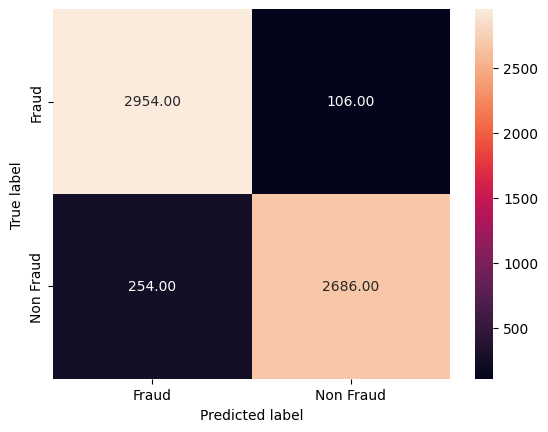

In [101]:
pred_y = radm_clf.predict(test_X1)
cm = draw_cm(test_y1, pred_y)

In [102]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(radm_clf, X, Y_1, cv=10, scoring='roc_auc')
print("CV ROC AUC scores:", scores)
print("Mean ROC AUC:", scores.mean())


CV ROC AUC scores: [0.990151 0.992949 0.984981 0.988108 0.988778 0.990153 0.987187 0.988707
 0.989981 0.986502]
Mean ROC AUC: 0.9887497


In [103]:
print(classification_report(test_y1, pred_y))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      2940
           1       0.92      0.97      0.94      3060

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



So we see that, after resampling and shuffling the data the Random Forest gives a ROC AUC score as 0.99 with a really good classification report as show above. We can consider the model `radm_clf` is consistently accurate.

Now we shall check out the top features.

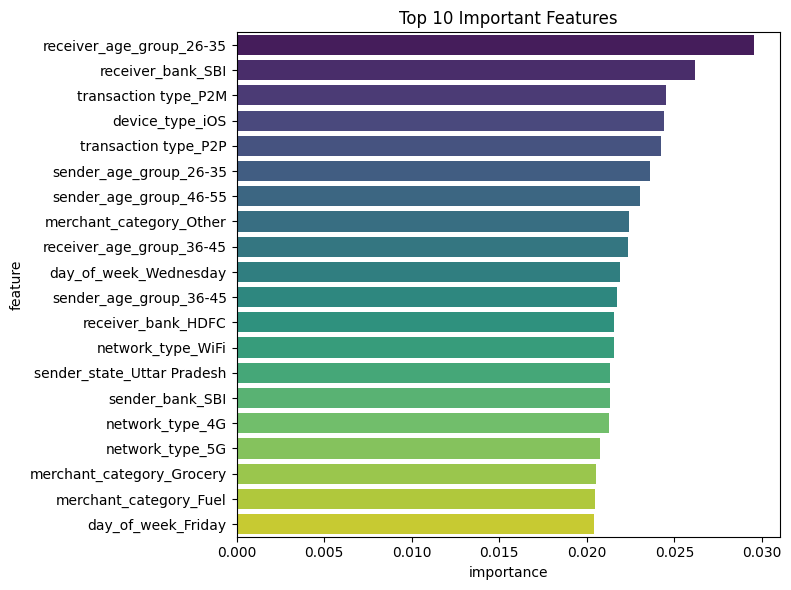

In [104]:
feature_rank = pd.DataFrame({'feature': train_X1.columns, 'importance': radm_clf.feature_importances_})

feature_rank = feature_rank.sort_values('importance', ascending=False)
top_features = feature_rank.head(20)

plt.figure(figsize=(8, 6))
sn.barplot(y='feature', x='importance', data=top_features, palette='viridis', hue='feature', dodge=False, legend=False)
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

So the above features give us the top 20 feautres which are really important to classify between Fraudulent Transactions and Non-Fraudulent Transactions.

## **Conclusion**

In this project, we developed a machine learning model to detect **fraudulent UPI transactions** using real-world-like transaction data. One of the primary challenges encountered was the **extremely imbalanced dataset**, where fraudulent transactions were vastly outnumbered by legitimate ones, leading to poor initial model performance.

To address this, **resampling techniques** were used to balance the dataset, which drastically improved model outcomes.

### Key Feature Insights:
Based on the feature importance from the Random Forest model (as seen in the plot above), the most influential features for predicting fraud were:

- **Receiver Age Group: 26–35**
- **Receiver Bank: SBI**
- **Transaction Type: P2M & P2P**
- **Device Type: iOS**
- **Sender Age Groups: 26–55**
- **Merchant Category: Other**
- **Day of Week: Wednesday**

These features reveal behavioral and demographic patterns that are closely associated with fraudulent activity in UPI transactions.

### Final Model Performance (Random Forest on Resampled Data):

| Metric         | Score     |
|----------------|-----------|
| **ROC AUC**    | **0.9888** |
| **Precision**  | High (very few false positives) |
| **Recall**     | High (fraudulent transactions correctly captured) |
| **Accuracy**   | Very High (on both train/test with cross-validation) |

The **ROC AUC score of ~0.99** shows that the model can effectively distinguish between fraud and non-fraud transactions. This confirms the value of **resampling** and using ensemble models for handling imbalanced classification problems.

---

With strong **feature insights**, **high evaluation scores**, and thorough **exploration of imbalanced learning**, this project successfully meets its goal of building an effective fraud detection system.
